In [10]:
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, metrics
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import *
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import seaborn as sns
import datetime
from time import sleep
import scipy.signal as signal 
import sys
sys.path.append('../../dsmuc/')
from dsmuc.custom import detect_peaks
from collections import Counter
sns.set(style="darkgrid")
from models import *

from __future__ import print_function

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics ,preprocessing
import pandas as pd
import itertools
import os
from sklearn.metrics import confusion_matrix

import math
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation,Flatten
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing import sequence
from sklearn.metrics import mean_squared_error
from keras.callbacks import Callback
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, AveragePooling1D

Using TensorFlow backend.


In [11]:
def extract_batch_size(_train, step, batch_size):
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data. 
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)

    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 

    return batch_s


def one_hot(y_):
    # Function to encode output labels from number indexes 
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    n_values = 6
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS
class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))

In [12]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    'accX',
    'accY', 
    'accZ', 
    'gyroX',
    'gyroY', 
    'gyroZ'
]

# Output classes to learn how to classify
LABELS = ['walking',
        'walking upstairs',
        'walking downstairs',
        'sitting',
        'standing',
        'laying']
RAW_DATA_PATH = "../../data/G9_data/Raw/snippets/"
def load_data(subject_no):
    Snippet_paths_training =[]
    Snippet_paths_test =[]
    for fol in LABELS:
        folder = RAW_DATA_PATH+'/'+fol+'/'  # folder = RAW_DATA_PATH+'/'+fol+'/'
        for root,dirs,files in os.walk(folder):
            for file_ in files:
                if file_.endswith(".csv"):
                    if int(file_.split("_")[0]) != subject_no:
                        Snippet_paths_training.append(folder+file_)
                    elif int(file_.split("_")[0]) == subject_no:
                        Snippet_paths_test.append(folder+file_)
                    
    X_signals_test = []
    y_signals_test = []
    usecols = INPUT_SIGNAL_TYPES + ['label']
    for snippet_path in Snippet_paths_test:
        df = pd.read_csv(snippet_path, usecols = usecols)
        y_signals_test.append(np.array(df['label'][0].reshape(1), dtype=np.int32))
        df = df[INPUT_SIGNAL_TYPES]
        c = df.values#.reshape(df.shape[0], df.shape[1])
        X_signals_test.append(c)
        
    X_signals_training = []
    y_signals_training = []
    usecols = INPUT_SIGNAL_TYPES + ['label']
    for snippet_path in Snippet_paths_training:
        df = pd.read_csv(snippet_path, usecols = usecols)
        y_signals_training.append(np.array(df['label'][0].reshape(1), dtype=np.int32))
        df = df[INPUT_SIGNAL_TYPES]
        c = df.values#.reshape(df.shape[0], df.shape[1])
        X_signals_training.append(c)
        
    return np.asarray(X_signals_training), np.asarray(y_signals_training),\
        np.asarray(X_signals_test), np.asarray(y_signals_test)



In [13]:
def get_class_weights(y):
    y = np.asarray(y)
    from sklearn.utils import class_weight
    class_weight = class_weight.compute_class_weight('balanced'
                                               ,np.unique(y.reshape(y.shape[0],))
                                               ,y.reshape(y.shape[0],))
    return  {cls: float(weight) for cls,weight in zip (np.unique(y.reshape(y.shape[0],)),class_weight)}


In [14]:
def auc_roc_plot(y_test, y_score, classes  = 'all'):
    from sklearn.metrics import roc_curve, auc
    if classes is None:
        classes = list(range(y_test.shape[1]))
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = len(classes)
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i],y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    
    

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = itertools.cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(classes, colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()
    

In [15]:
def plot_cm(cm, classes, normalize = True):
    import seaborn as sns
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap="Blues"); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes[::-1]);
    plt.xticks(rotation='vertical')
    plt.yticks(rotation='horizontal')
    plt.show()

In [32]:
def MLP():
    print('Build model...')

    model = Sequential()
    model.add(Dense(512, input_shape =(timesteps,)))
    model.add(Dense(512,activation='tanh'))
    model.add(Dense(512, activation='tanh'))
    model.add(Dense(512, activation='tanh'))
    model.add(Dense(256))
    model.add(Dense(256))
    model.add(Dense(32))
    model.add(Dense(n_classes, activation='sigmoid'))
    return model
def CNN():
    print('Build model...')
    model = Sequential()
    model.add(Conv1D(32,
                    16,
                     input_shape=(timesteps,1),
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(MaxPooling1D(6))
    model.add(Conv1D(64,
                    8,
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(MaxPooling1D(6))
    model.add(Conv1D(128,
                    4,
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(MaxPooling1D(6))
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Dense(64))
    model.add(Dense(n_classes, activation='softmax'))

    return model

In [33]:
#LOO-Validation on each subject
subjects = []
for fol in LABELS:
    folder = RAW_DATA_PATH+'/'+fol+'/'  # folder = RAW_DATA_PATH+'/'+fol+'/'
    for root,dirs,files in os.walk(folder):
        for file_ in files:
            if file_.endswith(".csv"):
                subjects.append(int(file_.split('_')[0]))
subject_list = np.unique(subjects)

In [34]:
subject_list

array([  1,   3,   4,   5,   6,   7,   8,   9,  10,  11,  13,  14,  15,
        16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
        29,  30, 101, 102, 103, 104, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117, 118, 119, 120])

In [19]:
model_name = "../../STM_WATCH/models_8May/modelCNN"

In [20]:
print('Loading Model: '+model_name)
from keras.models import model_from_json
json_file = open(model_name+'.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights(model_name+".h5")
model.summary()

Loading Model: ../../STM_WATCH/models_8May/modelCNN
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 737, 32)           1056      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 722, 64)           32832     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 715, 128)          65664     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_1 (Dropout)     

In [36]:
model = CNN()
model.summary()

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 753, 32)           544       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 125, 32)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 118, 64)           16448     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 19, 64)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 16, 128)           32896     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 2, 128)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 256)               0     

Model tested on subjects with no :  8
Reading the data...
Build model...
Train on 33458 samples, validate on 1061 samples
Epoch 1/100
33458/33458 [==============================] - 2s 73us/step - loss: 0.9867 - acc: 0.6272 - val_loss: 1.2386 - val_acc: 0.4684
Epoch 2/100
33458/33458 [==============================] - 2s 47us/step - loss: 0.7424 - acc: 0.7221 - val_loss: 1.6538 - val_acc: 0.2535
Epoch 3/100
33458/33458 [==============================] - 2s 48us/step - loss: 0.6723 - acc: 0.7470 - val_loss: 1.2103 - val_acc: 0.4854
Epoch 4/100
33458/33458 [==============================] - 2s 51us/step - loss: 0.6247 - acc: 0.7639 - val_loss: 1.3096 - val_acc: 0.4383
Epoch 5/100
33458/33458 [==============================] - 2s 47us/step - loss: 0.5962 - acc: 0.7724 - val_loss: 1.5241 - val_acc: 0.3025
Epoch 6/100
33458/33458 [==============================] - 2s 47us/step - loss: 0.5677 - acc: 0.7865 - val_loss: 1.0407 - val_acc: 0.6569
Epoch 7/100
33458/33458 [=========================

Epoch 59/100
33458/33458 [==============================] - 2s 47us/step - loss: 0.2073 - acc: 0.9175 - val_loss: 2.7379 - val_acc: 0.4430
Epoch 60/100
33458/33458 [==============================] - 2s 49us/step - loss: 0.2039 - acc: 0.9194 - val_loss: 2.3019 - val_acc: 0.4854
Epoch 61/100
33458/33458 [==============================] - 2s 48us/step - loss: 0.2019 - acc: 0.9187 - val_loss: 2.6270 - val_acc: 0.4694
Epoch 62/100
33458/33458 [==============================] - 2s 46us/step - loss: 0.2017 - acc: 0.9200 - val_loss: 2.7410 - val_acc: 0.4467
Epoch 63/100
33458/33458 [==============================] - 2s 47us/step - loss: 0.1981 - acc: 0.9197 - val_loss: 2.6616 - val_acc: 0.4967
Epoch 64/100
33458/33458 [==============================] - 2s 53us/step - loss: 0.1938 - acc: 0.9230 - val_loss: 2.7826 - val_acc: 0.4411
Epoch 65/100
33458/33458 [==============================] - 2s 48us/step - loss: 0.1943 - acc: 0.9218 - val_loss: 2.7727 - val_acc: 0.4826
Epoch 66/100
33458/33458 [=

/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:71: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:73: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/legend.py:638: UserWarning: Unrecognized location "upper_left". Falling back on "best"; valid locations are
	lower left
	center right
	lower center
	upper left
	upper center
	lower right
	center
	best
	center left
	right
	upper right

  % (loc, '\n\t'.join(self.codes)))


Model tested on subjects with no :  7
Reading the data...
Build model...
Train on 33473 samples, validate on 1046 samples
Epoch 1/100
33473/33473 [==============================] - 2s 74us/step - loss: 1.0086 - acc: 0.6181 - val_loss: 0.5149 - val_acc: 0.8499
Epoch 2/100
33473/33473 [==============================] - 2s 46us/step - loss: 0.7585 - acc: 0.7146 - val_loss: 0.7457 - val_acc: 0.6788
Epoch 3/100
33473/33473 [==============================] - 2s 56us/step - loss: 0.6833 - acc: 0.7453 - val_loss: 0.9418 - val_acc: 0.6549
Epoch 4/100
33473/33473 [==============================] - 2s 46us/step - loss: 0.6347 - acc: 0.7612 - val_loss: 1.1365 - val_acc: 0.6587
Epoch 5/100
33473/33473 [==============================] - 2s 48us/step - loss: 0.5971 - acc: 0.7758 - val_loss: 1.1209 - val_acc: 0.7352
Epoch 6/100
33473/33473 [==============================] - 2s 48us/step - loss: 0.5711 - acc: 0.7841 - val_loss: 0.6411 - val_acc: 0.7314
Epoch 7/100
33473/33473 [=========================

Epoch 59/100
33473/33473 [==============================] - 2s 54us/step - loss: 0.2104 - acc: 0.9179 - val_loss: 1.3403 - val_acc: 0.7352
Epoch 60/100
33473/33473 [==============================] - 2s 46us/step - loss: 0.2073 - acc: 0.9180 - val_loss: 1.2614 - val_acc: 0.7419
Epoch 61/100
33473/33473 [==============================] - 2s 47us/step - loss: 0.2057 - acc: 0.9176 - val_loss: 1.2254 - val_acc: 0.7275
Epoch 62/100
33473/33473 [==============================] - 2s 48us/step - loss: 0.2050 - acc: 0.9199 - val_loss: 0.8316 - val_acc: 0.7419
Epoch 63/100
33473/33473 [==============================] - 2s 54us/step - loss: 0.2003 - acc: 0.9203 - val_loss: 1.3671 - val_acc: 0.7457
Epoch 64/100
33473/33473 [==============================] - 2s 46us/step - loss: 0.2013 - acc: 0.9195 - val_loss: 1.0481 - val_acc: 0.7438
Epoch 65/100
33473/33473 [==============================] - 2s 47us/step - loss: 0.1961 - acc: 0.9229 - val_loss: 0.7233 - val_acc: 0.7811
Epoch 66/100
33473/33473 [=

Epoch 17/100
33548/33548 [==============================] - 2s 51us/step - loss: 0.3950 - acc: 0.8481 - val_loss: 1.4519 - val_acc: 0.5891
Epoch 18/100
33548/33548 [==============================] - 2s 49us/step - loss: 0.3851 - acc: 0.8521 - val_loss: 1.2925 - val_acc: 0.5901
Epoch 19/100
33548/33548 [==============================] - 2s 46us/step - loss: 0.3743 - acc: 0.8561 - val_loss: 1.0543 - val_acc: 0.6777
Epoch 20/100
33548/33548 [==============================] - 2s 48us/step - loss: 0.3643 - acc: 0.8607 - val_loss: 1.3417 - val_acc: 0.5623
Epoch 21/100
33548/33548 [==============================] - 2s 53us/step - loss: 0.3569 - acc: 0.8624 - val_loss: 1.5485 - val_acc: 0.6045
Epoch 22/100
33548/33548 [==============================] - 2s 48us/step - loss: 0.3494 - acc: 0.8643 - val_loss: 1.3296 - val_acc: 0.6395
Epoch 23/100
33548/33548 [==============================] - 2s 47us/step - loss: 0.3371 - acc: 0.8694 - val_loss: 1.4149 - val_acc: 0.6138
Epoch 24/100
33548/33548 [=

Epoch 76/100
33548/33548 [==============================] - 2s 46us/step - loss: 0.1578 - acc: 0.9376 - val_loss: 2.6242 - val_acc: 0.5685
Epoch 77/100
33548/33548 [==============================] - 2s 51us/step - loss: 0.1544 - acc: 0.9381 - val_loss: 2.1647 - val_acc: 0.5953
Epoch 78/100
33548/33548 [==============================] - 2s 49us/step - loss: 0.1542 - acc: 0.9395 - val_loss: 1.9580 - val_acc: 0.6272
Epoch 79/100
33548/33548 [==============================] - 2s 48us/step - loss: 0.1536 - acc: 0.9405 - val_loss: 2.0803 - val_acc: 0.5808
Epoch 80/100
33548/33548 [==============================] - 2s 47us/step - loss: 0.1540 - acc: 0.9388 - val_loss: 2.0799 - val_acc: 0.5942
Epoch 81/100
33548/33548 [==============================] - 2s 50us/step - loss: 0.1491 - acc: 0.9404 - val_loss: 2.1352 - val_acc: 0.6200
Epoch 82/100
33548/33548 [==============================] - 2s 49us/step - loss: 0.1489 - acc: 0.9401 - val_loss: 2.4270 - val_acc: 0.6632
Epoch 83/100
33548/33548 [=

Epoch 34/100
34053/34053 [==============================] - 2s 47us/step - loss: 0.2897 - acc: 0.8906 - val_loss: 0.9415 - val_acc: 0.4850
Epoch 35/100
34053/34053 [==============================] - 2s 47us/step - loss: 0.2872 - acc: 0.8913 - val_loss: 1.0388 - val_acc: 0.4979
Epoch 36/100
34053/34053 [==============================] - 2s 52us/step - loss: 0.2809 - acc: 0.8930 - val_loss: 1.1571 - val_acc: 0.4721
Epoch 37/100
34053/34053 [==============================] - 2s 46us/step - loss: 0.2799 - acc: 0.8955 - val_loss: 0.9185 - val_acc: 0.4850
Epoch 38/100
34053/34053 [==============================] - 2s 46us/step - loss: 0.2673 - acc: 0.8969 - val_loss: 0.9300 - val_acc: 0.4871
Epoch 39/100
34053/34053 [==============================] - 2s 45us/step - loss: 0.2661 - acc: 0.8985 - val_loss: 1.0083 - val_acc: 0.4871
Epoch 40/100
34053/34053 [==============================] - 2s 56us/step - loss: 0.2613 - acc: 0.9003 - val_loss: 1.5382 - val_acc: 0.4807
Epoch 41/100
34053/34053 [=

Epoch 93/100
34053/34053 [==============================] - 2s 47us/step - loss: 0.1479 - acc: 0.9439 - val_loss: 1.2780 - val_acc: 0.4828
Epoch 94/100
34053/34053 [==============================] - 2s 47us/step - loss: 0.1452 - acc: 0.9433 - val_loss: 1.2198 - val_acc: 0.4764
Epoch 95/100
34053/34053 [==============================] - 2s 52us/step - loss: 0.1432 - acc: 0.9453 - val_loss: 1.1950 - val_acc: 0.4635
Epoch 96/100
34053/34053 [==============================] - 2s 48us/step - loss: 0.1446 - acc: 0.9457 - val_loss: 1.3417 - val_acc: 0.5021
Epoch 97/100
34053/34053 [==============================] - 2s 46us/step - loss: 0.1407 - acc: 0.9463 - val_loss: 1.2580 - val_acc: 0.5150
Epoch 98/100
34053/34053 [==============================] - 2s 46us/step - loss: 0.1447 - acc: 0.9436 - val_loss: 1.2186 - val_acc: 0.4807
Epoch 99/100
34053/34053 [==============================] - 2s 51us/step - loss: 0.1410 - acc: 0.9457 - val_loss: 1.2683 - val_acc: 0.4850
Epoch 100/100
34053/34053 [

Epoch 51/100
34045/34045 [==============================] - 2s 46us/step - loss: 0.2182 - acc: 0.9184 - val_loss: 1.0941 - val_acc: 0.4810
Epoch 52/100
34045/34045 [==============================] - 2s 46us/step - loss: 0.2157 - acc: 0.9175 - val_loss: 1.1114 - val_acc: 0.4831
Epoch 53/100
34045/34045 [==============================] - 2s 53us/step - loss: 0.2114 - acc: 0.9199 - val_loss: 0.9597 - val_acc: 0.4810
Epoch 54/100
34045/34045 [==============================] - 2s 47us/step - loss: 0.2103 - acc: 0.9185 - val_loss: 1.0420 - val_acc: 0.4726
Epoch 55/100
34045/34045 [==============================] - 2s 46us/step - loss: 0.2066 - acc: 0.9208 - val_loss: 0.9866 - val_acc: 0.4979
Epoch 56/100
34045/34045 [==============================] - 2s 46us/step - loss: 0.2051 - acc: 0.9203 - val_loss: 1.0437 - val_acc: 0.5000
Epoch 57/100
34045/34045 [==============================] - 2s 54us/step - loss: 0.2034 - acc: 0.9215 - val_loss: 1.2134 - val_acc: 0.4873
Epoch 58/100
34045/34045 [=

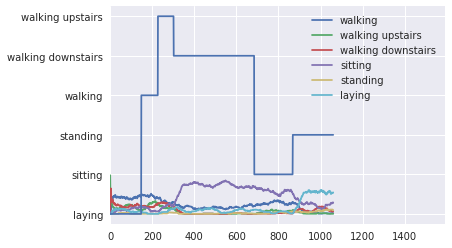

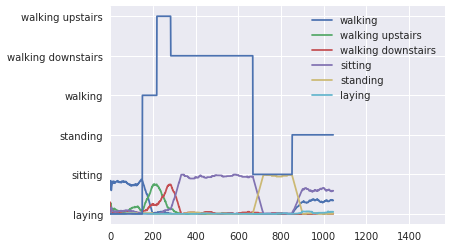

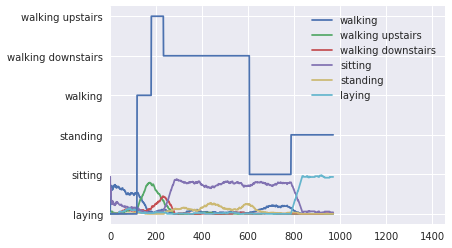

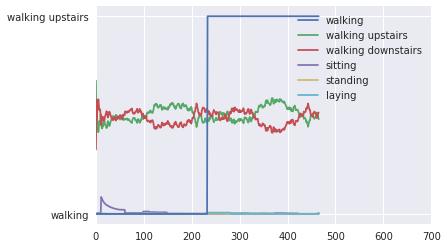

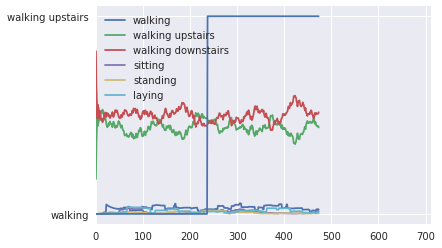

In [44]:

#LOO-Validation on each subject
subjects = []
for fol in LABELS:
    folder = RAW_DATA_PATH+'/'+fol+'/'  # folder = RAW_DATA_PATH+'/'+fol+'/'
    for root,dirs,files in os.walk(folder):
        for file_ in files:
            if file_.endswith(".csv"):
                subjects.append(int(file_.split('_')[0]))
subject_list = np.unique(subjects)
y_test_all = []
y_pred_all = []
y_score_all = []
np.random.seed(44)
iterations = np.array(list(itertools.combinations(subject_list, 1)))

it_index = np.random.choice(iterations.shape[0], replace=False,size=5)

for i in it_index: # two combination of tested subjects
    
    subject = iterations[i][0]
    print("==================")
    print('Model tested on subjects with no : ', subject)
    
    
    print('Reading the data...')
    X_train, y_train, X_test, y_test = load_data(subject)
    y_test = y_test - 1
    y_train = y_train - 1
    X_train_padded = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=128, dtype='float64',
        padding='pre', truncating='pre', value=0.)
    X_test_padded = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=128, dtype='float64',
        padding='pre', truncating='pre', value=0.)
    X_train_used = X_train_padded
    X_test_used = X_test_padded
    train_shape = X_train_used.shape
    test_shape = X_test_used.shape
    X_train_used = X_train_used.reshape(train_shape[0], -1,1)
    X_test_used = X_test_used.reshape(test_shape[0], -1,1)
    # Input Data 

    training_data_count = len(X_train_used)  # 7352 training series (with 50% overlap between each serie)
    test_data_count = len(X_test_used)  # 2947 testing series

    timesteps = len(X_train_used[0]) # 128 timesteps per series
    # input_dim = len(X_train_used[0][0]) # 6 input parameters per timestep

    # LSTM Neural Network's internal structure

    n_hidden = 32 # Hidden layer num of features
    n_classes = 6 # Total classes (should go up, or should go down)
    batch_size = 1500
    n_epoch = 100
    
    model = CNN()
    model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
    history =model.fit(X_train_used,
                  one_hot(y_train),
                  batch_size=128,
                  validation_data=(X_test_used, one_hot(y_test)),
                  epochs=n_epoch)
    
    
    y_score =  model.predict_proba(X_test_used)
    y_pred = y_score.argmax(1)
        
    y_score_all.extend(y_score)
    y_test_all.extend(list(y_test))
    y_pred_all.extend(list(np.argmax(pd.rolling_mean(y_score, 50,min_periods=1), axis=1)))
    plt.figure()
    plt.plot(pd.rolling_mean( y_score, 50,min_periods=1), "-")
    plt.xlim([0, 1.5*len(y_score)])
    plt.legend(['walking',
            'walking upstairs',
            'walking downstairs',
            'sitting',
            'standing',
            'laying'], loc='upper_left')
    a = np.asarray(y_test).astype(np.int)
    y_ticks = np.asarray(['walking',
            'walking upstairs',
            'walking downstairs',
            'sitting',
            'standing',
            'laying'])[a-1]
    plt.plot(y_ticks)
    plt.xlim([0, 1.5*len(y_score)])

Confusion matrix, without normalization


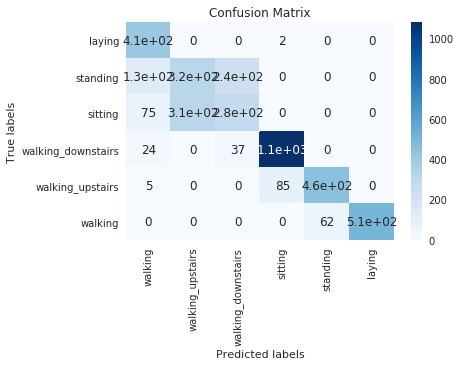

Normalized confusion matrix


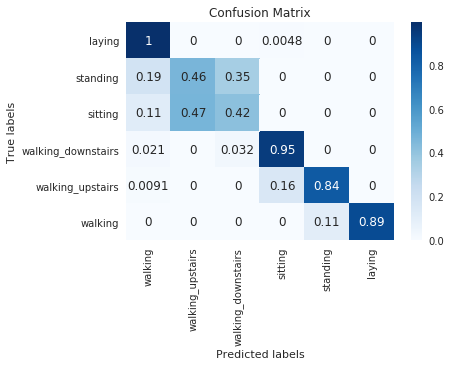

In [23]:
label_dict = {1:'walking',
             2:'walking_upstairs',
             3:'walking_downstairs',
             4:'sitting',
             5:'standing',
             6:'laying'}
class_names = list(label_dict.values())


cnf_matrix = confusion_matrix(y_test_all, y_pred_all)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_cm(cnf_matrix, class_names, normalize=False)

# Plot normalized confusion matrix
plt.figure()
plot_cm(cnf_matrix, class_names, normalize=True)
# plt.savefig(save_with_name+'.png')
plt.show()

In [24]:
true_pos = np.diag(cnf_matrix).sum()
accuracy = true_pos/float(cnf_matrix.sum())
print('Overall accuracy of the Model', accuracy)

Overall accuracy of the Model 0.7600796416127427


In [26]:
from sklearn.metrics import classification_report
print(classification_report([_[0] for _ in y_test_all], y_pred_all,target_names=class_names))

                    precision    recall  f1-score   support

           walking       0.64      1.00      0.78       416
  walking_upstairs       0.50      0.46      0.48       679
walking_downstairs       0.50      0.42      0.46       663
           sitting       0.93      0.95      0.94      1142
          standing       0.88      0.84      0.86       548
            laying       1.00      0.89      0.94       570

       avg / total       0.76      0.76      0.75      4018



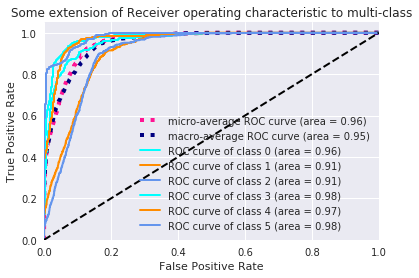

In [27]:
auc_roc_plot(one_hot(np.array(y_test_all)), np.array(y_score_all), None)

## Statistical Testing of the classifiers

In [ ]:
from scipy.stats import ttest_rel

In [ ]:
asd = classification_report(y_test_all, y_pred_all,target_names=class_names)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
log_first = [0.71, 0.31, 0.64, 0.87, 0.79, 0.66]
svm = [0.64, 0.34, 0.66, 0.89, 0.73, 0.61]
log_with_l1 = [0.62, 0.50, 0.68, 0.80, 0.70, 0.69]
LSTM = [0.72, 0.64, 0.83, 0.91, 0.82, 0.75]

In [ ]:
from __future__ import print_function
print("LSTM and logistic regression",ttest_rel( LSTM, log_first))
print("SVM and logistic regression",ttest_rel( svm, log_first))
print("LSTM and SVM regression",ttest_rel( LSTM, svm))
print("Regularized logistic regression and logistic regression",ttest_rel( log_with_l1, log_first))
print("SVM and regularized logistic regression ",ttest_rel( svm, log_with_l1))
print("LSTM and  regularized logistic regression ",ttest_rel( LSTM, log_with_l1))

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
